In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

In [3]:
import nltk
from nltk.corpus import gutenberg
nltk.download("gutenberg")
import re
from sklearn.model_selection import train_test_split



[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\jesst\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter

In [6]:
def text_cleaner(text):
    text = re.sub(r"--", " ", text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = " ".join(text.split())
    return text

In [7]:
emma = gutenberg.paras("austen-emma.txt")


In [8]:
emma_paras = []
for paragraph in emma:
    para = paragraph[0]
    para = [re.sub(r"--", "", word) for word in para]
    emma_paras.append(" ".join(para))

print(emma_paras[:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [9]:
from nltk.corpus import gutenberg, stopwords
from collections import Counter

In [10]:
emma_paras_df = pd.DataFrame(emma_paras)

In [11]:
emma_paras_df.head()

,0
0,[ Emma by Jane Austen 1816 ]
1,VOLUME I
2,CHAPTER I
3,"Emma Woodhouse , handsome , clever , and rich ..."
4,She was the youngest of the two daughters of a...


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=.5, min_df=2,
                            stop_words="english",
                            lowercase=True,
                            use_idf=True,
                            norm=u"l2",
                            smooth_idf=True)


In [14]:
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

Number of features: 1948


In [15]:
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

In [16]:
n = X_train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]


In [17]:
terms = vectorizer.get_feature_names()

for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]

In [18]:
print("Original sentenct:", X_train[5])
print("Tf_idf vector:", tfidf_bypara[5])

Original sentenct: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [35]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components", total_variance*100)


Percent variance captured by all components 45.198152009443874


In [20]:
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print("Component {}: ".format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0: 
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
Name: 0, dtype: float64
Component 1: 
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Name: 1, dtype: float64
Component 2: 
CHAPTER I      0.998647
CHAPTER V      0.998647
CHAPTER I      0.998647
CHAPTER I      0.998647
CHAPTER X      0.998647
CHAPTER X      0.998647
CHAPTER V      0.998647
CHAPTER V      0.998647
CHAPTER X      0.998647
CHAPTER XII    0.997554
Name: 2, dtype: float64
Component 3: 
" Ah !      0.992901
" Ah !      0.992901
" Ah !"     0.992901
" Ah !      0.992901
" Ah !      0.992901
But ah !    0.992901
" Ah !      0.992901
" Ah !      0.992901
" Ah !      0.992901
" Ah !      0.992901
Name: 3, dtype: float64
Component 4: 
" There were misunderstandings between them , Emma ; he said so expressly .    0.650782
Emma demurred .                                                                0.598770
" Are you well , my Emma ?"                                                    0.598770
Emma was silenced .                                                            0.587602
At first it was downright dulness to Emma .                                    0.587

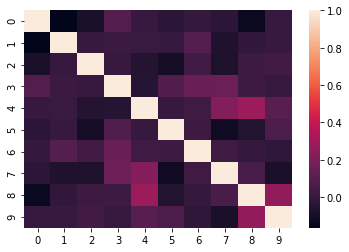

Key: 
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on bein

In [21]:
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[:10,:10]

ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

print("Key: ")
for i in range(10):
    print(i,sim_matrix.index[i])

In [22]:
sim_matrix[sim_matrix[0] > .1]

,0,1,2,3,4,5,6,7,8,9
That is _court_ .,1.0,-0.164062,-0.085559,0.087338,0.004783,-0.031076,-0.004805,-0.029086,-0.129685,0.006908


### Drill 0: Test Set
Now it's your turn: Apply our LSA model to the test set. Does it identify similar sentences for components 0 through 4?

In [23]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

lsa_trained = lsa.fit(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)



In [25]:
test_paras_by_component = pd.DataFrame(X_test_lsa, index=X_test)
for i in range(5):
    print("Component {}: ".format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0: 
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
" Oh !    0.999287
Name: 0, dtype: float64
Component 1: 
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Name: 1, dtype: float64
Component 2: 
CHAPTER I      0.998647
CHAPTER V      0.998647
CHAPTER I      0.998647
CHAPTER I      0.998647
CHAPTER X      0.998647
CHAPTER X      0.998647
CHAPTER V      0.998647
CHAPTER V      0.998647
CHAPTER X      0.998647
CHAPTER XII    0.997554
Name: 2, dtype: float64
Component 3: 
" Ah !      0.992901
" Ah !      0.992901
" Ah !"     0.992901
" Ah !      0.992901
" Ah !      0.992901
But ah !    0.992901
" Ah !      0.992901
" Ah !      0.992901
" Ah !      0.992901
" Ah !      0.992901
Name: 3, dtype: float64
Component 4: 
" There were misunderstandings between them , Emma ; he said so expressly .    0.650782
Emma demurred .                                                                0.598770
" Are you well , my Emma ?"                                                    0.598770
Emma was silenced .                                                            0.587602
At first it was downright dulness to Emma .                                    0.587

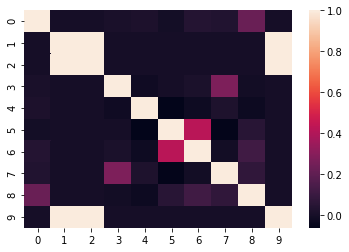

Key: 
0 Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .
1 " Oh !
2 " Oh no , no !
3 Such was Jane Fairfax ' s history .
4 " That has been a good deal the case , my dear ; but not to the degree you mention .
5 " And I am quite serious too , I assure you ," replied Mrs . Elton gaily , " in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us ."
6 " And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !"
7 " You may well class the delight , the honour , and the comf

In [26]:
similarity = np.asarray(np.asmatrix(X_test_lsa) * np.asmatrix(X_test_lsa).T)

sim_matrix = pd.DataFrame(similarity, index=X_test).iloc[:10,:10]

ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

print("Key: ")
for i in range(10):
    print(i,sim_matrix.index[i])

In [27]:
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

sim_matrix2 = pd.DataFrame(similarity, index=X_train)

sim_matrix2.head()

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
That is _court_ .,1.000000,-0.164062,-0.085559,0.087338,0.004783,-0.031076,-0.004805,-0.029086,-0.129685,0.006908,...,0.065895,0.091305,-0.109623,-0.005330,-0.023722,0.238807,-0.065880,0.082840,0.050018,0.102223
""" Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me .""",-0.164062,1.000000,0.004862,0.017256,0.010669,0.000300,0.092416,-0.065668,-0.012093,0.007839,...,-0.009222,-0.029894,0.225653,-0.028599,-0.004239,-0.001085,-0.003493,-0.003725,-0.018513,-0.009087
""" How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .",-0.085559,0.004862,1.000000,0.007822,-0.053455,-0.096431,0.039848,-0.074865,0.026413,0.036601,...,0.036538,-0.024235,0.038655,0.061674,0.010940,-0.023176,0.019993,-0.031896,-0.000018,0.009799
"To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up her hand seized her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping fearing adoring ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being seriously accepted as soon as possible .",0.087338,0.017256,0.007822,1.000000,-0.046690,0.077936,0.152790,0.156101,0.018387,0.007282,...,0.185982,0.027601,-0.003913,0.035248,0.063260,0.039524,0.013807,0.061470,0.036187,0.177112
"Emma smiled and answered "" My visit was of use to the nervous part of her complaint , I hope ; but not even I can charm away a sore throat ; it is a most severe cold indeed .",0.004783,0.010669,-0.053455,-0.046690,1.000000,0.008106,0.028104,0.223867,0.288054,0.102717,...,0.183526,0.211410,0.000278,-0.004708,0.033336,0.001774,0.034299,-0.022114,0.050699,-0.017883


In [28]:
sim_matrix2.describe()

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
count,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,...,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000
mean,-0.002074,0.025836,0.008001,0.044966,0.029207,0.012000,0.039617,0.010797,0.013066,0.027628,...,0.056013,0.045278,0.021604,0.017725,0.038361,0.010194,0.038493,0.014113,0.039391,0.047438
std,0.097199,0.086158,0.069452,0.084324,0.081815,0.079117,0.083216,0.079255,0.083060,0.084706,...,0.099305,0.088591,0.088351,0.079519,0.091129,0.080325,0.086862,0.083660,0.103702,0.095443
min,-0.364799,-0.164062,-0.130205,-0.151148,-0.264323,-0.233258,-0.130658,-0.245398,-0.129767,-0.263697,...,-0.130413,-0.214901,-0.109623,-0.167771,-0.193410,-0.084063,-0.107891,-0.140567,-0.111657,-0.116567
25%,-0.052511,-0.008769,-0.016768,-0.005128,-0.013039,-0.023160,-0.005128,-0.026552,-0.020760,-0.011523,...,-0.002717,-0.004868,-0.011460,-0.018082,-0.010562,-0.010838,-0.006372,-0.012961,-0.010273,-0.007917
50%,0.001208,0.000000,0.000000,0.020496,0.008109,0.000163,0.009991,0.000578,0.000000,0.003899,...,0.019404,0.019092,0.000000,0.000400,0.005761,-0.000447,0.003694,0.000000,0.003737,0.007313
75%,0.052933,0.014362,0.019993,0.077643,0.050359,0.030312,0.060167,0.034552,0.019971,0.040658,...,0.091638,0.085178,0.017669,0.031261,0.053125,0.010117,0.039598,0.017464,0.047922,0.077831
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
sim_matrix2[sim_matrix2[0] > .33]

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
That is _court_ .,1.0,-0.164062,-0.085559,0.087338,0.004783,-0.031076,-0.004805,-0.029086,-0.129685,0.006908,...,0.065895,0.091305,-0.109623,-0.00533,-0.023722,0.238807,-0.06588,0.08284,0.050018,0.102223


In [30]:
sim_matrix2[sim_matrix2[1] > .47]

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
""" Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me .""",-0.164062,1.000000,0.004862,0.017256,0.010669,0.000300,0.092416,-0.065668,-0.012093,0.007839,...,-0.009222,-0.029894,0.225653,-0.028599,-0.004239,-0.001085,-0.003493,-0.003725,-0.018513,-0.009087
""" Both sir !",-0.165493,0.474239,0.027467,0.002234,-0.000924,0.002533,0.001078,0.001037,0.002262,-0.005881,...,-0.003501,0.001472,-0.007640,0.012017,-0.001285,-0.001483,0.002462,-0.002955,0.001966,-0.006209
""" Have you indeed , sir ? Bless me !",-0.165493,0.474239,0.027467,0.002234,-0.000924,0.002533,0.001078,0.001037,0.002262,-0.005881,...,-0.003501,0.001472,-0.007640,0.012017,-0.001285,-0.001483,0.002462,-0.002955,0.001966,-0.006209
""" So very kind !""",-0.111451,0.490915,-0.013119,0.012194,0.065019,-0.020115,-0.024346,-0.053001,-0.021828,0.023437,...,0.001530,-0.033714,0.022521,-0.059082,0.031669,-0.010244,-0.014253,-0.015404,-0.056194,0.007153
""" Not at all , sir .",-0.165493,0.474239,0.027467,0.002234,-0.000924,0.002533,0.001078,0.001037,0.002262,-0.005881,...,-0.003501,0.001472,-0.007640,0.012017,-0.001285,-0.001483,0.002462,-0.002955,0.001966,-0.006209
""" Yes I imagined that is I did not """,-0.049902,0.527936,-0.011627,0.003351,0.000007,-0.029558,0.164065,0.006604,-0.026651,-0.023021,...,0.012517,-0.010235,0.385961,0.021719,-0.022757,-0.016621,0.008519,0.003878,-0.010096,-0.025206
""" Very well , I am much obliged to you .",-0.007904,0.518867,-0.000735,0.039640,-0.017369,0.044637,0.005667,-0.060169,-0.011426,0.002136,...,0.003742,0.006717,0.010340,-0.003756,-0.017182,0.006939,0.014886,-0.007825,0.008573,-0.005942


In [86]:
sim_matrix2[sim_matrix2[2] > .5].sort_values(2, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
""" How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .",0.003305,0.002378,1.000000,0.033688,0.015647,-0.075318,0.059866,-0.039170,0.039267,-0.035098,...,0.011531,0.029968,-0.020423,-0.056902,-0.008228,0.002337,0.011103,-0.004658,-0.008744,0.057532
That is _ship_ ; plain as it can be . Now for the cream .,0.009432,-0.020356,0.836338,0.099936,0.008397,-0.032718,0.090459,-0.039912,0.043067,-0.008964,...,0.044660,0.033907,-0.017034,-0.082561,-0.043774,-0.004841,-0.015070,0.006436,-0.011219,0.009273
""" He is very plain , undoubtedly remarkably plain : but that is nothing compared with his entire want of gentility .",0.026358,-0.007243,0.796838,0.062827,-0.029657,0.004541,0.071085,-0.032224,0.027906,0.025476,...,0.061507,0.073437,-0.029287,-0.040143,-0.071702,0.014093,-0.012649,0.016860,-0.019250,0.010313
""" You speak too plain .",-0.012510,-0.005114,0.679846,0.200839,0.036118,0.040242,0.262069,-0.015105,0.014351,-0.008825,...,0.056177,0.021692,-0.006445,-0.046617,0.008678,0.005874,0.006124,0.002431,-0.021793,0.002911
""" My dear , you said that Miss Campbell would not allow him to be plain , and that you yourself """,-0.080184,-0.017673,0.564266,0.050527,-0.016049,0.026401,0.051884,-0.036560,0.011475,-0.014901,...,0.096970,-0.022994,-0.022859,-0.051495,-0.013322,-0.016998,0.093125,0.015848,0.015318,0.009813
""" You are speaking of letters of business ; mine are letters of friendship .""",0.068225,0.093377,0.511107,0.029770,-0.016202,0.007142,0.002161,0.045541,-0.053397,0.046215,...,0.017918,0.088047,-0.005109,0.028493,0.018885,0.029748,-0.011493,-0.027306,-0.043432,0.044016


**Findings:** In general, there wasn't a great deal of similarity when I pulled the sentences with the highest similarity scores. A couple of the sentences above were very similar, but most had just one word in common (for example, "plain").

### Drill 1: Tweaking tf-idf
Go back up to the code where we originally translated the text from words to numbers. There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, and many others as well. We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities. Change things up a few times and see how that affects the results of the LSA. Write up your observations and share them with your mentor.

**Findings:** The initial run had an explained variance percentage of 45.7%. When the min_df (minimum document frequency) was increased to .7 (70% of the documents had to contain it) and the max_df (maximum document frequency) was increased to 5, the percent explained variance was 55.8%. The contents of the components were rather similar with the exception of Component 4 that had fewer overlaps in documents. When I lowered the min_df to .2, the percent explained variance was 45.2% and the components were similar.





Get it done:
+ change the min and max df based on the similarity that i'm seeing

<h1><center>max_df is .2 and min_df is 2</center></h1>

In [87]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=.2, min_df=2,
                            stop_words="english",
                            lowercase=True,
                            use_idf=True,
                            norm=u"l2",
                            smooth_idf=True)


In [88]:
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

Number of features: 1948


In [89]:
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

In [90]:
n = X_train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]


In [91]:
terms = vectorizer.get_feature_names()

for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]

In [92]:
print("Original sentenct:", X_train[5])
print("Tf_idf vector:", tfidf_bypara[5])

Original sentenct: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [93]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components", total_variance*100)


Percent variance captured by all components 45.2027371682007


In [94]:
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print("Component {}: ".format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0: 
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
" Oh !     0.999289
Name: 0, dtype: float64
Component 1: 
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634584
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.564350
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.564148
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.562287
Mr . Knightley might qua

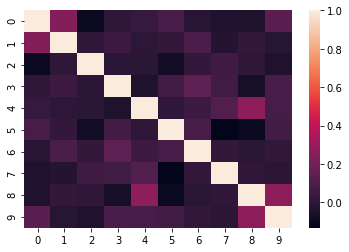

Key: 
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on bein

In [95]:
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[:10,:10]

ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

print("Key: ")
for i in range(10):
    print(i,sim_matrix.index[i])

In [96]:
sim_matrix3 = pd.DataFrame(similarity, index=X_train)


In [98]:
sim_matrix3[sim_matrix3[1] > .5].sort_values(1, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
""" Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me .""",0.244993,1.000000,0.005713,0.052730,0.001338,0.019454,0.088750,-0.022005,0.019637,-0.016459,...,-0.003376,-0.061671,0.208425,0.026126,0.010717,-0.007071,-0.002934,0.011920,-0.004262,-0.008388
""" Yes I imagined that is I did not """,0.288865,0.527018,-0.020938,0.021524,0.010301,-0.024227,0.168313,-0.000687,-0.009023,-0.003224,...,0.003996,-0.030690,0.371616,0.005773,-0.034446,-0.014962,-0.007907,-0.004561,-0.016792,-0.018359
""" Very well , I am much obliged to you .",0.040550,0.511181,0.007937,0.054501,0.009253,0.024070,-0.031634,-0.030722,0.030910,-0.026789,...,0.017607,-0.008498,-0.003464,0.059765,-0.016204,0.003427,-0.006375,0.000253,0.004478,-0.004396


In [100]:
sim_matrix3[sim_matrix3[2] > .47].sort_values(2, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
""" How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .",-0.100339,0.005713,1.000000,-0.006241,-0.008564,-0.076747,0.021734,0.053773,0.007574,-0.035867,...,0.015581,0.031995,-0.013675,0.011034,0.003325,-0.034628,0.005863,-0.049518,-0.044050,-0.021009
That is _ship_ ; plain as it can be . Now for the cream .,-0.094570,-0.015146,0.867604,0.072980,0.005689,-0.015899,0.059616,-0.004571,0.020094,-0.008526,...,0.054286,-0.010117,-0.002965,-0.005161,-0.016030,-0.025731,0.010167,-0.049642,-0.031307,-0.052882
""" He is very plain , undoubtedly remarkably plain : but that is nothing compared with his entire want of gentility .",-0.063073,-0.003166,0.826877,0.037426,-0.017431,0.004467,0.036823,-0.026404,0.007565,0.014585,...,0.055030,0.022615,-0.015506,0.025941,-0.021328,-0.018858,0.015318,-0.026495,-0.031875,-0.041613
""" You speak too plain .",-0.099286,-0.006109,0.706247,0.172562,0.022725,0.059251,0.245211,0.012105,0.015839,-0.021710,...,0.048828,-0.031225,-0.010324,0.002086,0.000821,-0.012478,0.022552,-0.026109,-0.007507,-0.044431
""" My dear , you said that Miss Campbell would not allow him to be plain , and that you yourself """,-0.025379,-0.024158,0.601242,0.059882,-0.005808,0.056027,0.037256,-0.014559,-0.000890,-0.016996,...,0.098983,-0.046985,-0.002489,-0.016198,0.012815,-0.022667,0.116772,-0.024812,-0.008566,-0.013328
""" You are speaking of letters of business ; mine are letters of friendship .""",-0.008878,0.082125,0.493096,0.026545,0.005407,0.005512,0.013816,0.097768,0.007370,0.026387,...,0.038226,0.120335,-0.008439,0.049642,-0.017185,-0.040115,-0.035698,0.003938,-0.013485,0.044512


In [102]:
sim_matrix3[sim_matrix3[4] > .5].sort_values(4, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
"Emma smiled and answered "" My visit was of use to the nervous part of her complaint , I hope ; but not even I can charm away a sore throat ; it is a most severe cold indeed .",0.030975,0.001338,-0.008564,-0.039977,1.000000,0.005526,0.048726,0.110660,0.272820,0.077220,...,0.183178,0.206600,0.019884,0.024701,0.019653,0.005605,0.037288,-0.034865,0.017279,-0.018750
""" I have some hope ,"" resumed he , "" of my uncle ' s being persuaded to pay a visit at Randalls ; he wants to be introduced to her .",0.067962,0.027645,-0.004650,0.027328,0.663567,0.052686,0.020249,0.092683,0.021885,0.011978,...,0.179137,0.047419,-0.017571,-0.028640,0.000150,-0.013073,-0.002430,-0.054857,0.033995,0.003086


<h1><center>max_df is .7 and min_df is 5</center></h1>

In [103]:
X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=.7, min_df=5,
                            stop_words="english",
                            lowercase=True,
                            use_idf=True,
                            norm=u"l2",
                            smooth_idf=True)


In [104]:
emma_paras_tfidf = vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

Number of features: 799


In [105]:
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

In [106]:
n = X_train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]


In [107]:
terms = vectorizer.get_feature_names()

for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i,j]

In [108]:
print("Original sentenct:", X_train[5])
print("Tf_idf vector:", tfidf_bypara[5])

Original sentenct: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [109]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("Percent variance captured by all components", total_variance*100)


Percent variance captured by all components 55.90542638089724


In [110]:
paras_by_component = pd.DataFrame(X_train_lsa, index=X_train)
for i in range(5):
    print("Component {}: ".format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0: 
" Oh !     0.999068
" Oh !     0.999068
" Oh !"    0.999068
" Oh !     0.999068
" Oh !     0.999068
" Oh !     0.999068
" Oh !     0.999068
" Oh !     0.999068
" Oh !     0.999068
" Oh !     0.999068
Name: 0, dtype: float64
Component 1: 
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.708431
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.616767
Mr . Knightley might quarrel with her , but Emma could not quarrel with herself .                                                                                           0.615467
" There were misunderstandings between them , Emma ; he said so expressly .                                                                                                 0.608388
Emma found that it was n

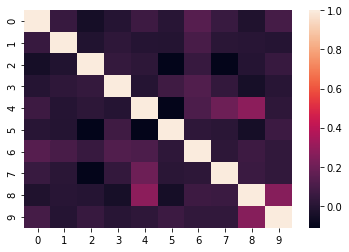

Key: 
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on bein

In [111]:
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)

sim_matrix = pd.DataFrame(similarity, index=X_train).iloc[:10,:10]

ax = sns.heatmap(sim_matrix, yticklabels=range(10))
plt.show()

print("Key: ")
for i in range(10):
    print(i,sim_matrix.index[i])

In [112]:
sim_matrix4 = pd.DataFrame(similarity, index=X_train)


In [113]:
sim_matrix4[sim_matrix4[1] > .5].sort_values(1, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
""" Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me .""",0.048987,1.000000,-0.013773,0.025816,-0.001684,-0.007079,0.099934,0.010875,0.006139,-0.000728,...,-0.006596,-0.053907,0.251572,-0.036344,-0.014327,-0.001119,-0.001024,0.004189,-0.003584,0.003235
""" Yes I imagined that is I did not """,0.042533,0.568888,-0.045833,0.017930,0.004169,-0.008666,0.187277,0.004935,-0.002691,-0.003231,...,0.021965,0.004203,0.388587,0.013085,-0.016519,-0.013812,-0.005972,-0.003291,-0.015779,-0.010486
""" Very well , I am much obliged to you .",0.008095,0.514689,-0.004534,0.009097,0.002946,0.013156,-0.020584,0.009033,0.041112,-0.017681,...,0.001622,-0.012355,0.010988,-0.022378,-0.026317,0.005857,0.004604,0.000699,0.002249,0.011659


In [114]:
sim_matrix4[sim_matrix4[2] > .47].sort_values(2, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
""" How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .",-0.049823,-0.013773,1.000000,0.039616,0.017635,-0.112840,0.049603,-0.107253,-0.002767,0.052060,...,-0.022538,-0.010228,-0.007377,-0.020318,-0.028311,-0.019123,0.010410,0.001573,-0.021906,0.037289
That is _ship_ ; plain as it can be . Now for the cream .,-0.059744,-0.042360,0.815240,0.096530,0.006793,-0.015087,0.109017,-0.075652,-0.017304,0.048278,...,0.049390,-0.002990,0.020700,-0.020438,-0.072751,-0.011694,-0.013485,0.012364,-0.004557,0.005684
""" He is very plain , undoubtedly remarkably plain : but that is nothing compared with his entire want of gentility .",-0.060971,-0.029728,0.779464,0.077449,-0.027872,0.001592,0.087753,-0.077208,-0.027928,0.077145,...,0.083127,0.057068,0.014297,0.032176,-0.075801,0.009298,-0.020380,0.029150,-0.023013,-0.001287
""" You speak too plain .",-0.029534,-0.029626,0.689159,0.195203,0.041298,0.060578,0.245665,-0.043541,-0.015962,0.034639,...,0.036014,0.014658,0.017900,-0.044893,-0.054873,-0.005273,0.001497,-0.002304,-0.012018,0.021048
""" My dear , you said that Miss Campbell would not allow him to be plain , and that you yourself """,0.071946,-0.043312,0.521131,0.029758,-0.018280,0.067456,0.090182,-0.027482,-0.014422,0.009800,...,0.094129,-0.051718,0.020038,-0.019305,-0.022749,-0.022081,0.113836,0.014972,0.032101,0.015668
"Emma could not forgive her ; but as neither provocation nor resentment were discerned by Mr . Knightley , who had been of the party , and had seen only proper attention and pleasing behaviour on each side , he was expressing the next morning , being at Hartfield again on business with Mr . Woodhouse , his approbation of the whole ; not so openly as he might have done had her father been out of the room , but speaking plain enough to be very intelligible to Emma .",0.093224,-0.006300,0.475304,0.118376,0.072437,-0.071336,0.066234,-0.145289,-0.074492,0.005336,...,0.080181,0.166009,-0.012012,0.099116,0.078894,-0.006584,0.017457,0.002000,0.269396,0.012381


In [115]:
sim_matrix4[sim_matrix4[4] > .5].sort_values(4, ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421
"Emma smiled and answered "" My visit was of use to the nervous part of her complaint , I hope ; but not even I can charm away a sore throat ; it is a most severe cold indeed .",0.067404,-0.001684,0.017635,-0.000663,1.000000,-0.104807,0.109494,0.199750,0.281972,0.023769,...,0.159076,0.284271,0.005071,0.020647,0.002641,-0.003251,0.048651,-0.008348,0.040788,-0.021704
""" I have some hope ,"" resumed he , "" of my uncle ' s being persuaded to pay a visit at Randalls ; he wants to be introduced to her .",-0.000777,0.032478,-0.026677,0.039928,0.595588,-0.037485,-0.021801,0.139613,0.021641,-0.033585,...,0.237171,0.167043,-0.006310,0.032754,0.003859,-0.026654,-0.018284,-0.031860,-0.002446,-0.035443


**Findings:** The similarity of sentences was not incredibly different with different max_df and min_df. The slightly more effective max_df is .7 and the min_df is 5.